# Building Structures with ASE

In [1]:
import matplotlib.pyplot as plt

from ase import build
from ase.io import read
from ase.visualize import view

from abtem.plot import plot_atoms
from abtem.transform import orthogonalize_atoms

In this lesson we show how to use The Atomic Simulation Environment [(ASE)](https://wiki.fysik.dtu.dk/ase/) to create supercells for doing image simulations. ASE is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is used in conjunction with other codes such as GPAW for running DFT simulations. Here we focus on the basic tools and concepts necessary for creating electrostatic potentials for image simulation with abTEM.

## Importing Strontium Titanate
ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). In this example, we will import a unit cell of Strontium Titanate, SrTiO2. Other structures can be downloaded from databases such as the Inorganic Crystal Structure Database [(ICSD)](https://icsd.products.fiz-karlsruhe.de/).

In [2]:
srtio = read('data/SrTiO.cif') # read atomic structure file
srtio

Atoms(symbols='SrTiO3', pbc=True, cell=[3.905, 3.905, 3.905], tags=...)

In ASE the atomic structure is represented by the [Atoms object](https://wiki.fysik.dtu.dk/ase/ase/atoms.html). This objects describes, amongst other things, the position and atomic number of each atom and the unit cell. These quantities can be accessed and changed with get and set-methods as shown below.

In [3]:
print(srtio.get_positions(), '\n')
print(srtio.get_atomic_numbers(), '\n')
print(srtio.get_cell())

[[0.     0.     0.    ]
 [1.9525 1.9525 1.9525]
 [1.9525 1.9525 0.    ]
 [1.9525 0.     1.9525]
 [0.     1.9525 1.9525]] 

[38 22  8  8  8] 

Cell([3.905, 3.905, 3.905], pbc=True)


The atomic structure can be visualized using the function `abtem.plot.plot_atoms`. This function shows a 2d projection of the structure perpendicular to the specified plane. abTEM assumes propagation along the $z$-axis with the entrance plane at $z=0$, hence the $xy$-plane corresponds to the imaging plane.

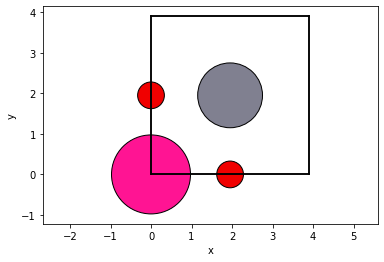

In [4]:
plot_atoms(srtio, plane='xy')

The above unit cell is fine for simulating a High-Resolution Transmission Electron Microscopy (HRTEM) image, however simulating a Scanning Transmission Electron Microscopy (STEM) image requires a [supercell](https://en.wikipedia.org/wiki/Supercell_(crystal)) large enough to accomodate the probe. This will be described in detail later. Below we show how to repeat the unit cell to create a larger simulation supercell cell. 
We can show two directions side-by-side with `plot_atoms` using normal `matplotlib` commands.

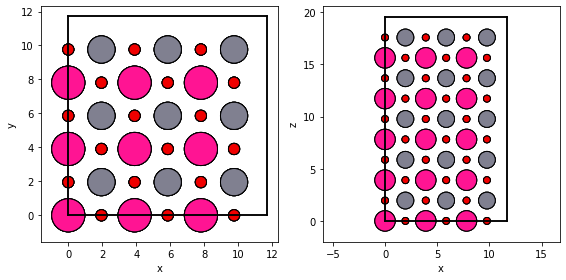

In [5]:
repeated_srtio = srtio * (3, 3, 5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_atoms(repeated_srtio, ax=ax1)
plot_atoms(repeated_srtio, ax=ax2, plane='xz')
plt.tight_layout()

## Arbitrary directions in SrTiO
The [`surface`](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html?highlight=surface#ase.build.surface) function can be used for creating an arbitrary surface given its miller indices.

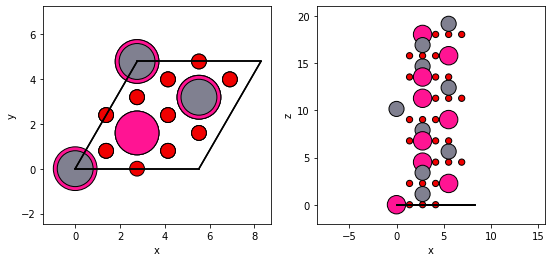

In [6]:
surf = build.surface(srtio, indices=(1, 1, 1), layers=9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
plot_atoms(surf, ax=ax1)
plot_atoms(surf, ax=ax2, plane='xz')

There is two issues with the created surface structure, the unit cell has zero height and the unit cell is nonorthogonal. The first issue is easily solved with the [`.center()`](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.center) method. This method centers and adds additional vaccuum to the atoms along a specified set of axes. The second problem is sometimes more difficult to resolve, however here we can straightforwardly use `orthogonalize_atoms` function. Consult the documentation if you find that this function creates a too large or strained unit cell.

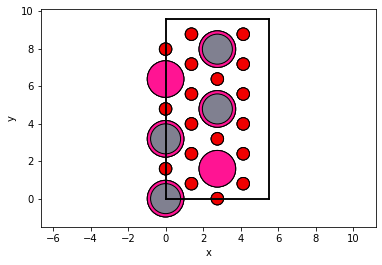

In [7]:
surf.center(axis=2, vacuum=2)

orthogonal_surf = orthogonalize_atoms(surf)

plot_atoms(orthogonal_surf, plane='xy')

## Carbon nanotube
ASE also includes modules for creating special structures such as [carbon nanotubes](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes) and [nanoparticles](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html). Here we create a type $(6,0)$ nanotube. 

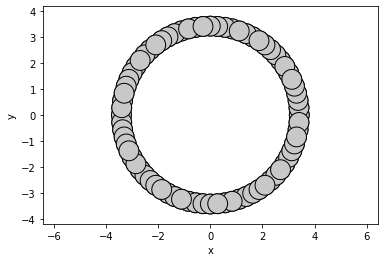

In [8]:
cnt = build.nanotube(6, 4, length=1)

plot_atoms(cnt)

As we can see above, the current propagation direction is along the length of the nanotube. To rotate the nanotube we use the method [`.rotate()`](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate).

In [10]:
rotated_cnt = cnt.copy()
rotated_cnt.rotate(90, 'y', rotate_cell=True)

rotated_cnt.center(vacuum=5, axis=(0,1))

rotated_cnt = orthogonalize_atoms(rotated_cnt, 1, 1)


plot_atoms(rotated_cnt)

RuntimeError: 

## Graphite, graphene and other 2D materials

Graphite can be created with the `Graphite` class. 

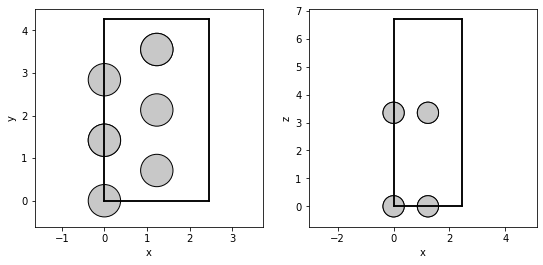

In [38]:
from ase.lattice.hexagonal import Graphite

graphite = Graphite(symbol = 'C', latticeconstant = {'a' : 2.46, 'c' : 6.7})

graphite = orthogonalize_atoms(graphite)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
plot_atoms(graphite, scale_atoms=.5, ax=ax1)
plot_atoms(graphite, scale_atoms=.5, ax=ax2, plane='xz')

To make graphene we just have to extract one of the layer from the graphite. We use boolean indexing from the to select all atoms that has a position with a $z$-component greater than 1 Å.

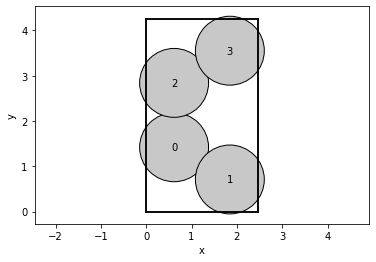

In [39]:
graphene = graphite[graphite.positions[:,2] > 1]

graphene.center(vacuum=2, axis=2) # reduce amount of vacuum
graphene.center()

#graphene = graphene.repeat((4,2,1))

plot_atoms(graphene, scale_atoms=1, numbering=True)

We can create hexagonal boron nitride by changing the atomic numbers accordingly. To see which atoms to change, we set `numbering=True` when plotting the atoms above.  For materials such as MoS2 check out the [`mx2`](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html?highlight=mx2#ase.build.mx2) module.

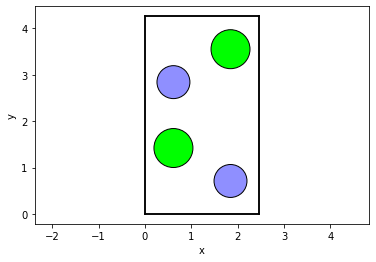

In [40]:
hbn = graphene.copy()

hbn.numbers[0] = 5
hbn.numbers[3] = 5
hbn.numbers[1] = 7
hbn.numbers[2] = 7

plot_atoms(hbn, scale_atoms=.5)

## Interactive visualization and creation

ASE includes a [graphical user interface](https://wiki.fysik.dtu.dk/ase/ase/gui/gui.html) that allows users to visualize, manipulate, and render molecular systems and atoms objects. It can be started using the `view` function, alternatively it can be started from the terminal using the command `ase-gui`.

In [41]:
view(orthogonal_surf)